In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.classifier import (
    ConfusionMatrix
)

# Importar xgboost
import xgboost as xgb

sns.set_palette("colorblind")
SEED = 42

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://0.0.0.0:5000")

In [3]:
df_path = "../data/processed/hotel_bookings.csv"
df = pd.read_csv(df_path)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,City Hotel,0,20,2017,May,21,23,0,1,2,...,No Deposit,9.0,NaN,0,Transient,150.0,0,1,Check-Out,2017-05-24
1,City Hotel,0,191,2017,August,32,11,2,5,2,...,No Deposit,168.0,NaN,0,Transient,112.1,0,0,Check-Out,2017-08-18
2,City Hotel,0,121,2016,July,30,23,1,1,2,...,No Deposit,9.0,NaN,0,Transient,105.3,0,0,Check-Out,2016-07-25
3,City Hotel,0,2,2016,July,27,1,0,1,2,...,No Deposit,14.0,NaN,0,Transient,147.0,0,0,Check-Out,2016-07-02
4,City Hotel,0,12,2017,May,21,23,0,1,1,...,No Deposit,8.0,NaN,0,Transient,110.0,0,1,Check-Out,2017-05-24


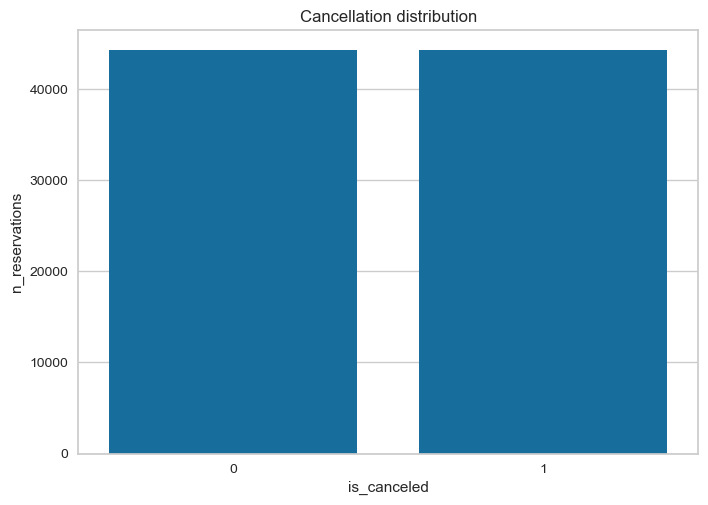

In [6]:
sns.barplot(
    data = (df
            .groupby(['is_canceled'])
            .size()
            .reset_index(name = 'n_reservations')),
    x = 'is_canceled',
    y = 'n_reservations'
)
plt.title("Cancellation distribution")
plt.show()

In [19]:
y = df.is_canceled
X = df.drop(columns = 'is_canceled')

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']
variable_selection_categoric = ['customer_type','deposit_type']               # <--- Selecciona las variable categóricas

def prep_for_ml(tbl_train, tbl_val, tbl_test, variable_selection_numeric, variable_selection_categoric, scaled:bool = False):
    '''Clean X_train and X_test
        1) Select continuous and categorical variables.
        2) Convert categorical variables to one hot encoding
        3) Concatenate clean dataframes
    '''
    # Continuous variables
    tbl_num_train = tbl_train.loc[:, variable_selection_numeric]
    tbl_num_val = tbl_val.loc[:, variable_selection_numeric]
    tbl_num_test = tbl_test.loc[:, variable_selection_numeric]

    if scaled is True:
        train_scaled = StandardScaler().fit_transform(tbl_num_train)
        val_scaled = StandardScaler().fit_transform(tbl_num_val)
        test_scaled = StandardScaler().fit_transform(tbl_num_test)

        tbl_num_train = pd.DataFrame(train_scaled, columns=tbl_num_train.columns)
        val_scaled = pd.DataFrame(val_scaled, columns=tbl_num_val.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=tbl_num_test.columns)


    # Categorical variables
    tbl_cat_train = tbl_train.loc[:, variable_selection_categoric]
    tbl_cat_val = tbl_val.loc[:, variable_selection_categoric]
    tbl_cat_test = tbl_test.loc[:, variable_selection_categoric]

    ohe = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output=False)
    ohe.fit(tbl_cat_train)
    col_names = ohe.get_feature_names_out()

    tbl_ohe_cat_train = pd.DataFrame(
        ohe.transform( tbl_cat_train )
    )

    tbl_ohe_cat_val = pd.DataFrame(
        ohe.transform( tbl_cat_val )
    )

    tbl_ohe_cat_test = pd.DataFrame(
        ohe.transform( tbl_cat_test )
    )
    # Add new column names
    tbl_ohe_cat_train.columns = col_names
    tbl_ohe_cat_val.columns = col_names
    tbl_ohe_cat_test.columns = col_names

    # Join transformed continuous + categorical variables
    tbl_train_clean = pd.concat([tbl_num_train.reset_index(drop = True), tbl_ohe_cat_train], axis = 1)
    tbl_val_clean = pd.concat([tbl_num_val.reset_index(drop = True), tbl_ohe_cat_val], axis = 1)
    tbl_test_clean = pd.concat([tbl_num_test.reset_index(drop = True), tbl_ohe_cat_test], axis = 1)

    return (tbl_train_clean, tbl_val_clean, tbl_test_clean)



In [21]:
def model_insigth_pipeline(
    clf,
    experiment_name: str,
    X: pd.DataFrame, 
    y: pd.Series,
    compare_results: pd.DataFrame, 
    variable_selection_categoric: list = None,
    variable_selection_numeric: list = None,
    scaled: bool = False,
):
    # Create a new MLflow Experiment
    mlflow.set_experiment(experiment_name) 
    
    if not variable_selection_numeric:
        variable_selection_numeric = [
            'arrival_date_week_number',
            'stays_in_weekend_nights',
            'stays_in_week_nights',
            'lead_time',
            'total_of_special_requests',
            'is_repeated_guest',
            'previous_cancellations',
            'previous_bookings_not_canceled',
        ]
    if not variable_selection_categoric:
        variable_selection_categoric = [
            'hotel',
            'market_segment',
            'deposit_type',
            'customer_type',
            'meal'
        ]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=SEED,
        stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=X_test.shape[0],
        random_state=SEED,
        stratify=y_train
    )    
    X_train_clean, X_val_clean, X_test_clean = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
        scaled
    )
    
    clf_model = clf.fit(X_train_clean, y_train)
    predictions = clf_model.predict(X_test_clean)
    
    insight = {
        'auc': roc_auc_score(y_test, predictions),
        'score': f1_score(y_test, predictions) ,
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions),
        'accuracy': accuracy_score(y_test, predictions)
    }
    
    # Start an MLflow run
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf_model.get_params())

        # Log the loss metric
        mlflow.log_metrics(insight)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "Basic Clasifier model for Enigine Health")

        # Infer the model signature
        signature = infer_signature(X_train, clf_model.predict(X_train))

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf_model,
            artifact_path="cancellation_prediction_model",
            signature=signature,
            input_example=X_train,
            registered_model_name="tracking"+experiment_name,
        )
    
    results = pd.DataFrame(insight, index=[compare_results.shape[0]])
    
    compare_results = pd.concat([compare_results,results], ignore_index=True)
    
    display(compare_results)

    cm = ConfusionMatrix(
        clf,
        classes=['not cancelled','cancelled']
    )
    cm.fit(X_train, y_train)
    cm.score(X_val, y_val)
    cm.show()

    return clf_model, compare_results

In [18]:
compare_results = pd.DataFrame(columns=['model','auc','score','precision','recall'])

models = {
    'Logistic regression': LogisticRegression(random_state=SEED),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SGDC': SGDClassifier(random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(random_state=SEED),
    'XGBoost': xgb.XGBClassifier(random_state=SEED),
}

for name, model in models.items():
    _,compare_results = model_insigth_pipeline(
        model,
        experiment_name=name,
        X=X,
        y=y,
        compare_results=compare_results,
    )

2024/09/11 14:04:19 INFO mlflow.tracking.fluent: Experiment with name 'Logistic regression' does not exist. Creating a new experiment.


NameError: name 'X_train' is not defined